### Set the environment by importing the necessary dependencies

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

### Load the data, check for null values and duplicates, and check the data types

In [3]:
# uploading the data
flights_data = pd.read_csv("flight_dataset.csv")
print(flights_data.head())
flights_data.drop(columns=["Unnamed: 0"],inplace=True)

# checking for null and duplicated values, and the data type of the variables
print(flights_data.isna().sum())
print(flights_data.duplicated().sum())
print(flights_data.info())

   Unnamed: 0   airline   flight source_city departure_time stops  \
0           0  SpiceJet  SG-8709       Delhi        Evening  zero   
1           1  SpiceJet  SG-8157       Delhi  Early_Morning  zero   
2           2   AirAsia   I5-764       Delhi  Early_Morning  zero   
3           3   Vistara   UK-995       Delhi        Morning  zero   
4           4   Vistara   UK-963       Delhi        Morning  zero   

    arrival_time destination_city    class  duration  days_left  price  
0          Night           Mumbai  Economy      2.17          1   5953  
1        Morning           Mumbai  Economy      2.33          1   5953  
2  Early_Morning           Mumbai  Economy      2.17          1   5956  
3      Afternoon           Mumbai  Economy      2.25          1   5955  
4        Morning           Mumbai  Economy      2.33          1   5955  
airline             0
flight              0
source_city         0
departure_time      0
stops               0
arrival_time        0
destination_cit

### Check the correlation between the numerical variables

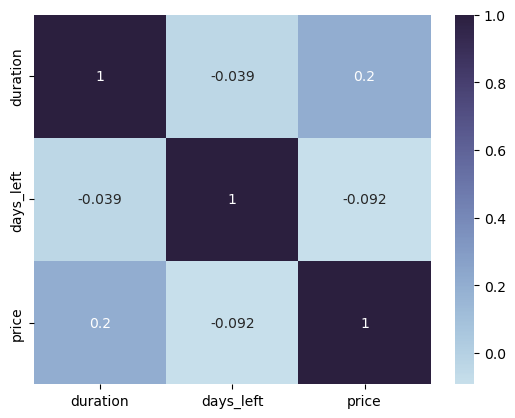

In [4]:
corr_df = flights_data.corr()
fig, ax = plt.subplots()
sns.heatmap(corr_df, annot=True, cmap=sns.color_palette('ch:s=.25,rot=-.25', as_cmap=True), ax=ax)
plt.savefig("Flight corr.png", dpi=300, bbox_inches='tight')
plt.show()

### Show the distribution of the numerical variables

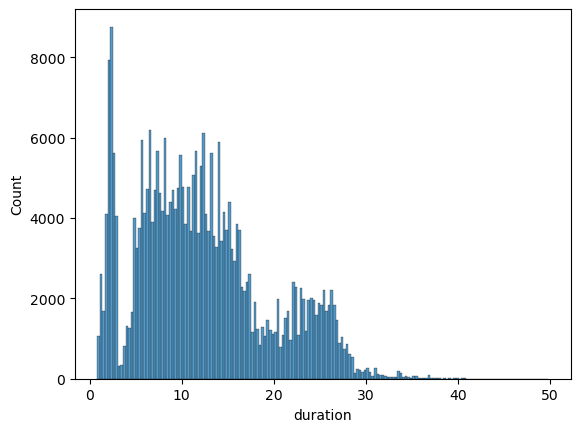

In [5]:
sns.histplot(data=flights_data['duration']);
plt.savefig("duration_distr.png", dpi=300, bbox_inches='tight')

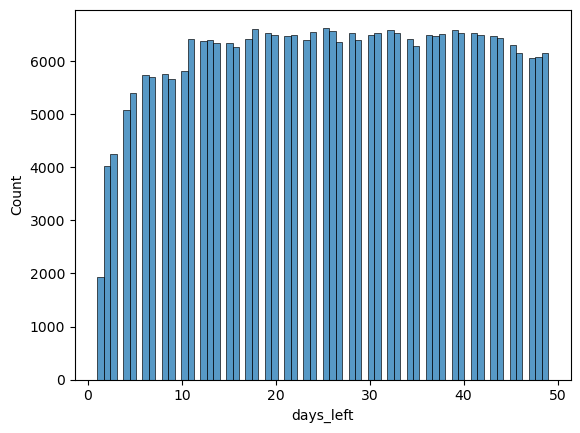

In [6]:
sns.histplot(data=flights_data['days_left']);
plt.savefig("daysleft_distr.png", dpi=300, bbox_inches='tight')

### Show the price according to the days left until the flight

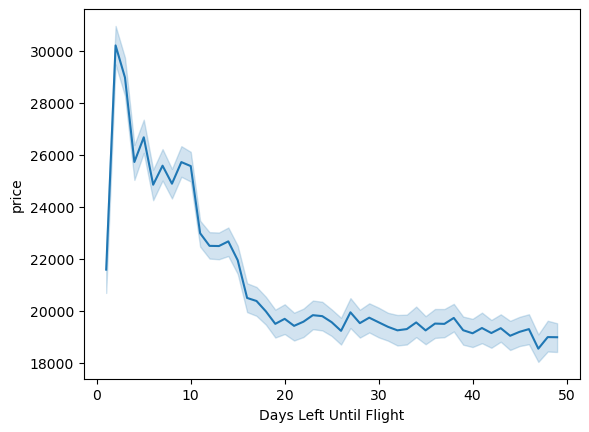

In [7]:
sns.lineplot(data=flights_data,x="days_left", y="price");
plt.xlabel("Days Left Until Flight")
plt.savefig("price_daysleft.png", dpi=300, bbox_inches='tight')
plt.show()

### Show the price according to the duration of the flight

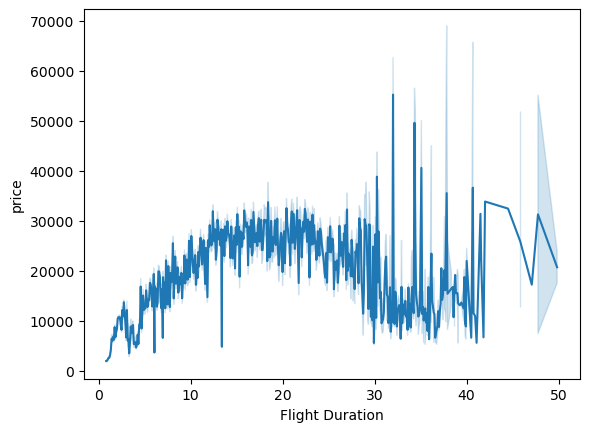

In [8]:
sns.lineplot(data=flights_data,x="duration", y="price");
plt.xlabel("Flight Duration")
plt.savefig("price_duration.png", dpi=300, bbox_inches='tight')
plt.show()

### Check the distribution of the target variable

/var/folders/ll/s4f5rf0s5z9gxj3tj3ry06m00000gn/T/ipykernel_56168/2610282285.py:6: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


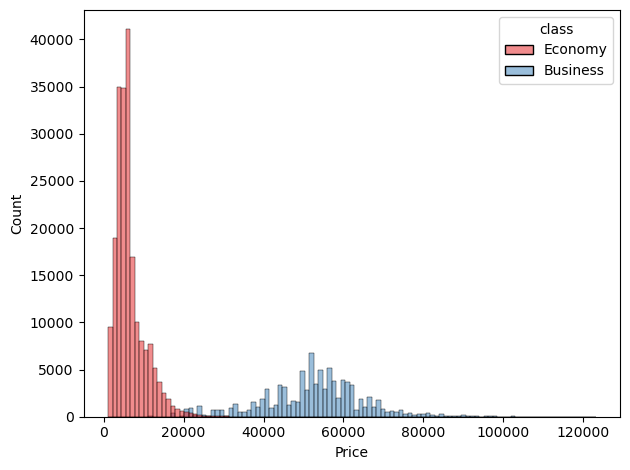

In [8]:
fig, ax = plt.subplots()
sns.histplot(data=flights_data, x="price", palette="Set1",hue="class", ax=ax)
plt.xlabel('Price')
fig.tight_layout()
plt.savefig("Target distribution.png", dpi=300, bbox_inches='tight')
fig.show()

### Show the range of price values for each of the class labels using box plots

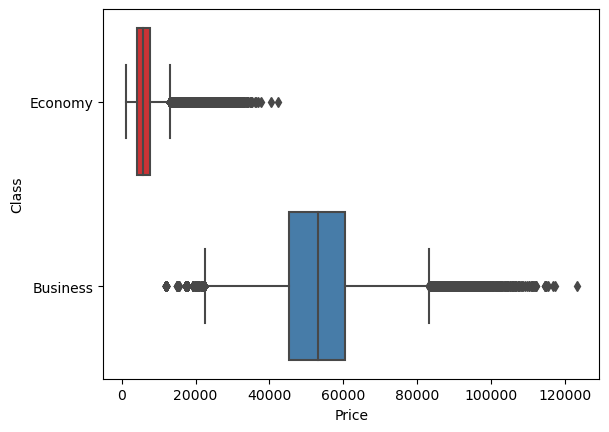

In [14]:
fig, ax = plt.subplots()
fig = sns.boxplot(data=flights_data,x="price", y="class", palette="Set1")
plt.xlabel('Price')
plt.ylabel('Class')
plt.savefig("Class_boxplots.png", dpi=300, bbox_inches='tight')
plt.show()

### Check the values of the categorical columns to decide on the best way to encode them

In [68]:
categorical_cols = ['airline','source_city','departure_time','arrival_time','destination_city','class','stops']
for col in categorical_cols:
    print(f"\n\n{col}\n\n",flights_data[f"{col}"].value_counts())



airline

 Vistara      127859
Air_India     80892
Indigo        43120
GO_FIRST      23173
AirAsia       16098
SpiceJet       9011
Name: airline, dtype: int64


source_city

 Delhi        61343
Mumbai       60896
Bangalore    52061
Kolkata      46347
Hyderabad    40806
Chennai      38700
Name: source_city, dtype: int64


departure_time

 Morning          71146
Early_Morning    66790
Evening          65102
Night            48015
Afternoon        47794
Late_Night        1306
Name: departure_time, dtype: int64


arrival_time

 Night            91538
Evening          78323
Morning          62735
Afternoon        38139
Early_Morning    15417
Late_Night       14001
Name: arrival_time, dtype: int64


destination_city

 Mumbai       59097
Delhi        57360
Bangalore    51068
Kolkata      49534
Hyderabad    42726
Chennai      40368
Name: destination_city, dtype: int64


class

 Economy     206666
Business     93487
Name: class, dtype: int64


stops

 one            250863
zero            3600

### Show the range of price values for each airline

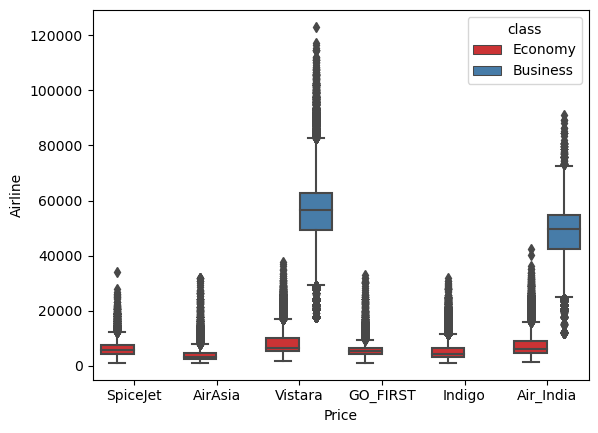

In [22]:
fig, ax = plt.subplots()
fig = sns.boxplot(data=flights_data,x="airline", y="price",hue="class",palette="Set1")
plt.xlabel('Price')
plt.ylabel('Airline')
plt.savefig("airlines_boxplots.png", dpi=300, bbox_inches='tight')
plt.show()

### Show the range of price values for each route

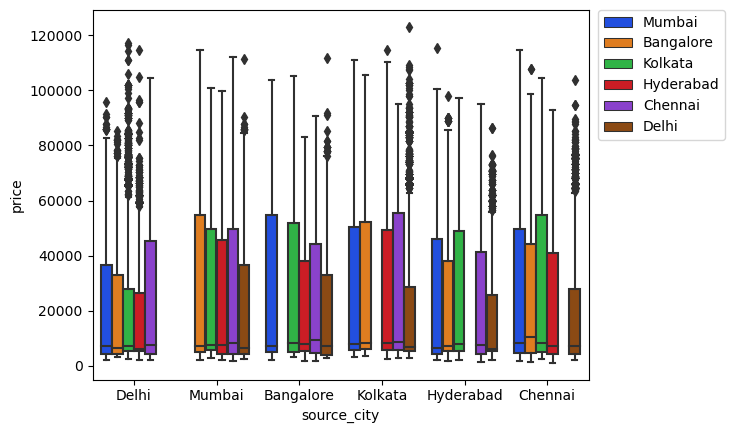

In [16]:
sns.boxplot(data=flights_data,x="source_city", y="price", hue="destination_city", palette="bright");
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

### Show the range of price values for the departure time and arrival time

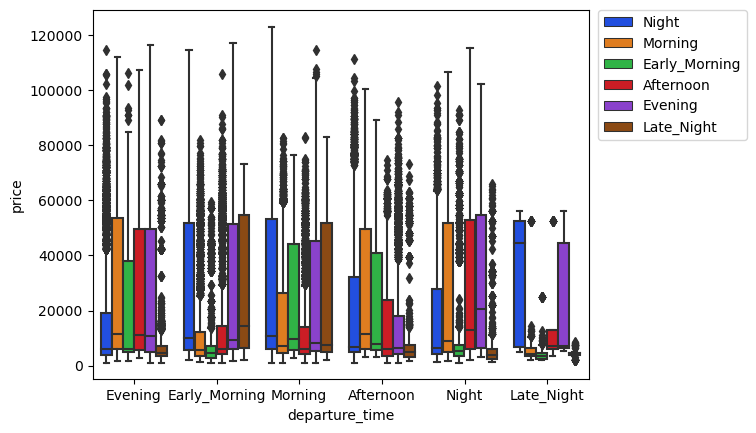

In [15]:
sns.boxplot(data=flights_data,x="departure_time", y="price", hue="arrival_time", palette="bright");
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0);

### Show the range of price values for the quantity of stops

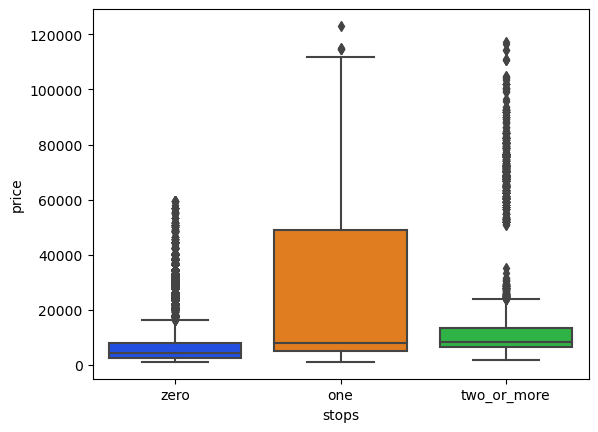

In [52]:
sns.boxplot(data=flights_data,x="stops", y="price", palette="bright");

## Stratifying the target variable then splitting the data into train and test sets

In [69]:
#the flight number column is not relevant for our analysis, so we drop it
flights_data.drop('flight',axis=1,inplace=True)

target = 'price'
features = ['airline', 'source_city', 'departure_time', 'stops', 'arrival_time',
       'destination_city', 'class', 'duration', 'days_left','bins']

# Calculate the cut values for the stratification bins
percentiles = [20, 40, 60, 80]
cut_values = flights_data[target].quantile([p/100 for p in percentiles])

# Create a new column with the bin labels
flights_data['bins'] = pd.cut(flights_data[target], bins=[-float("inf")] + list(cut_values) + [float("inf")])

# Split the data into training and testing sets, stratified by the bins
X_train, X_test, y_train, y_test = train_test_split(flights_data[features], flights_data[target], test_size=0.2, stratify=flights_data['bins'], random_state=42)

y_test = pd.DataFrame(y_test)
y_train = pd.DataFrame(y_train)

# Drop the bin column
X_train.drop('bins',axis=1,inplace=True)
X_test.drop('bins',axis=1,inplace=True)

## Encoding the categorical variables

In [70]:
X_train_transformed = pd.get_dummies(X_train, columns = categorical_cols[0:6],drop_first=True)
X_test_transformed = pd.get_dummies(X_test, columns = categorical_cols[0:6],drop_first=True)

X_train_transformed['stops'] = X_train_transformed['stops'].replace({'zero':0,'one':1,'two_or_more':2})
X_test_transformed['stops'] = X_test_transformed['stops'].replace({'zero':0,'one':1,'two_or_more':2})

## Scaling the numerical variables

In [71]:
num_cols = ['duration','days_left']
ct = ColumnTransformer(
    [('scale', StandardScaler(), num_cols)], 
    remainder='passthrough')

num_scaled_train = ct.fit_transform(X_train_transformed[['duration','days_left']])
num_scaled_test = ct.transform(X_test_transformed[['duration','days_left']])

X_train_transformed.iloc[:, 1:3] = num_scaled_train
X_test_transformed.iloc[:, 1:3] = num_scaled_test

scaler_target = StandardScaler()

y_train['price'] = scaler_target.fit_transform(y_train[['price']].values)
y_test['price'] = scaler_target.transform(y_test[['price']].values)

## Regression Models

### 1. Linear Regression

In [99]:
from sklearn.linear_model import LinearRegression

# Set up a regression model
lin_reg = LinearRegression()

# Fit the model on the training data
lin_reg.fit(X_train_transformed, y_train)

# Use the trained model to make predictions on the test set
y_pred = lin_reg.predict(X_test_transformed)

# Assessment metrics
mae_LR = mean_absolute_error(y_test, y_pred)
mse_LR = mean_squared_error(y_test, y_pred)
rmse_LR = np.sqrt(mse_LR)
r2_LR = r2_score(y_test, y_pred)

print("Mean absolute error:", mae_LR)
print("Root mean squared error:", rmse_LR)
print("R-squared:", r2_LR)

Mean absolute error: 0.1993366026424982
Root mean squared error: 0.30026841057955617
R-squared: 0.9096601200691319


### 2. Decision Tree

In [100]:
from sklearn.tree import DecisionTreeRegressor

# Set up a regression model
tree_reg = DecisionTreeRegressor()

# Fit the model on the training data
tree_reg.fit(X_train_transformed, y_train)

# Use the trained model to make predictions on the test set
y_pred = tree_reg.predict(X_test_transformed)

# Assessment metrics
mae_DT = mean_absolute_error(y_test, y_pred)
mse_DT = mean_squared_error(y_test, y_pred)
rmse_DT = np.sqrt(mse_DT)
r2_DT = r2_score(y_test, y_pred)

print("Mean absolute error:", mae_DT)
print("Root mean squared error:", rmse_DT)
print("R-squared:", r2_DT)

Mean absolute error: 0.051032282568945694
Root mean squared error: 0.15260707347594096
R-squared: 0.9766649064208512


### 3. Random Forest Regressor

In [102]:
from sklearn.ensemble import RandomForestRegressor

# Create a random forest regressor
rf = RandomForestRegressor(n_jobs=-1)

# Fit the model on the training data
rf.fit(X_train_transformed, y_train)

# Predict the target values for the test data
y_pred = rf.predict(X_test_transformed)

# Assessment metrics
mae_RF = mean_absolute_error(y_test, y_pred)
mse_RF = mean_squared_error(y_test, y_pred)
rmse_RF = np.sqrt(mse_RF)
r2_RF = r2_score(y_test, y_pred)

print("Mean absolute error:", mae_RF)
print("Root mean squared error:", rmse_RF)
print("R-squared:", r2_RF)

/var/folders/ll/s4f5rf0s5z9gxj3tj3ry06m00000gn/T/ipykernel_56168/2283953723.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_transformed, y_train)


Mean absolute error: 0.04734970543939342
Root mean squared error: 0.12186047704861012
R-squared: 0.9851205812363051


In [103]:
decision_trees = rf.estimators_

for tree_idx, tree in enumerate(decision_trees):
    depth = tree.tree_.max_depth
    leaf_samples = tree.tree_.n_node_samples[tree.tree_.children_left == -1]
    min_samples = leaf_samples.min()
    max_samples = leaf_samples.max()
    print(f"Decision Tree {tree_idx+1} Minimum Leaf Node Samples: {min_samples}")
    print(f"Decision Tree {tree_idx+1} Maximum Leaf Node Samples: {max_samples}")
    print(f"Decision Tree {tree_idx+1} Depth: {depth}\n")

Decision Tree 1 Minimum Leaf Node Samples: 1
Decision Tree 1 Maximum Leaf Node Samples: 205
Decision Tree 1 Depth: 40

Decision Tree 2 Minimum Leaf Node Samples: 1
Decision Tree 2 Maximum Leaf Node Samples: 220
Decision Tree 2 Depth: 41

Decision Tree 3 Minimum Leaf Node Samples: 1
Decision Tree 3 Maximum Leaf Node Samples: 193
Decision Tree 3 Depth: 40

Decision Tree 4 Minimum Leaf Node Samples: 1
Decision Tree 4 Maximum Leaf Node Samples: 197
Decision Tree 4 Depth: 40

Decision Tree 5 Minimum Leaf Node Samples: 1
Decision Tree 5 Maximum Leaf Node Samples: 201
Decision Tree 5 Depth: 40

Decision Tree 6 Minimum Leaf Node Samples: 1
Decision Tree 6 Maximum Leaf Node Samples: 178
Decision Tree 6 Depth: 41

Decision Tree 7 Minimum Leaf Node Samples: 1
Decision Tree 7 Maximum Leaf Node Samples: 190
Decision Tree 7 Depth: 42

Decision Tree 8 Minimum Leaf Node Samples: 1
Decision Tree 8 Maximum Leaf Node Samples: 260
Decision Tree 8 Depth: 43

Decision Tree 9 Minimum Leaf Node Samples: 1
Dec

### 4. KNN

In [97]:
from sklearn.neighbors import KNeighborsRegressor

knn = KNeighborsRegressor(n_neighbors=5)
knn.fit(X_train_transformed, y_train)

y_pred = knn.predict(X_test_transformed)

# Assessment metrics
mae_KNN = mean_absolute_error(y_test, y_pred)
mse_KNN = mean_squared_error(y_test, y_pred)
rmse_KNN = np.sqrt(mse_KNN)
r2_KNN = r2_score(y_test, y_pred)

print("Mean absolute error:", mae_KNN)
print("Root mean squared error:", rmse_KNN)
print("R-squared:", r2)

Mean absolute error: 0.08136385047957145
Root mean squared error: 0.16971895842028933
R-squared: 0.9851620669715031


### 5. SVR

In [ ]:
from sklearn.svm import SVR

y_train_numpy = y_train.to_numpy()
y_train_numpy = np.ravel(y_train_numpy)

# Create a Support Vector Regression model and fit it on the training data
svr = SVR()
svr.fit(X_train_transformed, y_train_numpy)

y_pred = svr.predict(X_test_transformed)

# Assessment metrics
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean absolute error:", mae)
print("Root mean squared error:", np.sqrt(mse))
print("R-squared:", r2)

#### From our assessment metrics we understood that the best performing model is the random forest regressor. Now, we can move on to tuning our hyperparameters.

In [45]:
X_train_transformed.reset_index(inplace=True)
y_train.reset_index(inplace=True)

# Split the training set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_transformed, y_train, test_size=0.2, random_state=42)

# First, we define our parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15],
    'min_samples_split': [15, 20, 25],
    'min_samples_leaf': [4, 6, 8]
}

from sklearn.model_selection import RandomizedSearchCV
random_search = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=30, cv=5, scoring='neg_mean_squared_error', random_state=42, n_jobs=-1)

# Fit the grid search to the training data
random_search.fit(X_train, y_train)

# Get the best hyperparameters and model
best_params = random_search.best_params_
best_model = random_search.best_estimator_

In [49]:
y_pred = best_model.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
mse = mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("Mean absolute error:", mae)
print("Root mean squared error:", np.sqrt(mse))
print("R-squared:", r2)

Mean absolute error: 0.7402699932841187
Mean squared root error: 1.2550826862460014
R-squared: 0.968984103758759


In [47]:
best_params

{'n_estimators': 200,
 'min_samples_split': 15,
 'min_samples_leaf': 8,
 'max_depth': 15}

In [81]:
# First, we define our parameter grid
param_grid = {
    'n_estimators': [200, 300],
    'max_depth': [15, 30, 45],
    'min_samples_split': [15, 25, 35],
    'min_samples_leaf': [8, 16, 24]
}

# Initialize GridSearchCV
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train_transformed, y_train)

# Evaluating the results by looking at our best performing parameter and estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680:

/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680:

/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680:

/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680:

/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680:

/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680:

/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680:

/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680:

/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680:

/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680:

In [82]:
best_params

{'max_depth': 30,
 'min_samples_leaf': 8,
 'min_samples_split': 15,
 'n_estimators': 300}

In [83]:
y_pred = best_estimator.predict(X_test_transformed)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean absolute error:", mae)
print("Root mean squared error:", np.sqrt(mse))
print("R-squared:", r2)

Mean absolute error: 0.055203046439131875
Root mean squared error: 0.12157258328395663
R-squared: 0.9851908030490645


In [84]:
# First, we define our parameter grid
param_grid = {
    'n_estimators': [300, 400],
    'max_depth': [30, 40, 50],
    'min_samples_split': [15],
    'min_samples_leaf': [8]
}

# Initialize GridSearchCV
from sklearn.model_selection import GridSearchCV
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)

# Fit the grid search to the training data
grid_search.fit(X_train_transformed, y_train)

# Evaluating the results by looking at our best performing parameter and estimator
best_params = grid_search.best_params_
best_estimator = grid_search.best_estimator_

/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680:

/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:680: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
/Users/jane/opt/anaconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:926: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


In [85]:
best_params

{'max_depth': 40,
 'min_samples_leaf': 8,
 'min_samples_split': 15,
 'n_estimators': 400}

In [86]:
y_pred = best_estimator.predict(X_test_transformed)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean absolute error:", mae)
print("Root mean squared error:", np.sqrt(mse))
print("R-squared:", r2)

Mean absolute error: 0.05517064412804081
Root mean squared error: 0.1216244215753753
R-squared: 0.985178171136247


## Model Selected

**The following parameters were chosen 'max_depth': 30, 'min_samples_leaf': 8, 'min_samples_split': 15, 'n_estimators': 300**

Even though the MAE of the Random Forest Regressor model with default parameters is lower, the minimum samples in leaf nodes is 1 so it is susceptible to noise and the max depth is much higher. This could lead to overfitting and may cause problems with new data. The RMSE and the R-squared values are slighly improved. Either way, in both cases the models are robust. The choice of the model thus aims to have a better generelazition.

In [96]:
from sklearn.ensemble import RandomForestRegressor

# Create a random forest regressor
rf = RandomForestRegressor(max_depth=30, min_samples_leaf=8,min_samples_split=15,n_estimators=300,n_jobs=-1)

# Fit the model on the training data
rf.fit(X_train_transformed, y_train)

# Predict the target values for the test data
y_pred = rf.predict(X_test_transformed)

# Assessment metrics
mae_RF_tuned = mean_absolute_error(y_test, y_pred)
mse_RF_tuned = mean_squared_error(y_test, y_pred)
rmse_RF_tuned = np.sqrt(mse)
r2_RF_tuned = r2_score(y_test, y_pred)

print("Mean absolute error:", mae_RF_tuned)
print("Root mean squared error:", rmse_RF_tuned)
print("R-squared:", r2_RF_tuned)

/var/folders/ll/s4f5rf0s5z9gxj3tj3ry06m00000gn/T/ipykernel_56168/1462344107.py:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  rf.fit(X_train_transformed, y_train)


Mean absolute error: 0.055209169488026386
Root mean squared error: 0.12169047712086942
R-squared: 0.9852011252343169


In [106]:
models = ['Linear Regression', 'Decision Tree', 'Random Forest Regressor', 'KNN', 'Tuned Random Forest Regressor']
mae = [mae_LR, mae_DT, mae_RF, mae_KNN, mae_RF_tuned]
rmse = [rmse_LR, rmse_DT, rmse_RF, rmse_KNN, rmse_RF_tuned]
r2 = [r2_LR, r2_DT, r2_RF, r2_KNN, r2_RF_tuned]

performance_metrics = pd.DataFrame()

performance_metrics['Models'] = models
performance_metrics['MAE'] = mae
performance_metrics['RMSE'] = rmse
performance_metrics['R-Squared'] = r2

print(performance_metrics)

                          Models       MAE      RMSE  R-Squared
0              Linear Regression  0.199337  0.300268   0.909660
1                  Decision Tree  0.051032  0.152607   0.976665
2        Random Forest Regressor  0.047350  0.121860   0.985121
3                            KNN  0.081364  0.169719   0.971138
4  Tuned Random Forest Regressor  0.055209  0.121690   0.985201
